In [1]:
%matplotlib inline

import numpy as np
import os
import utils
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.cross_validation
import sklearn.linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from mpl_toolkits.mplot3d import Axes3D

Загрузим датасет

In [2]:
X, y = utils.load_prices()

Модель крайне простая -- считаем линейную формулу с коэффициентами

In [3]:
def predict(X, params):
    return np.hstack((np.ones((X.shape[0], 1)), X)).dot(params)

Так как в X у нас всего два фактора, то можно легко визуализировать весь датасет в трехмерном пространстве:

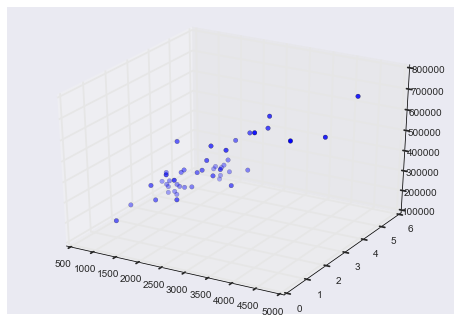

In [4]:
#%matplotlib qt 
def plot_regression(X_tr, y_tr, X_test, y_test, line):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tr[:, 0], X_tr[:, 1], y_tr)
    if (X_test is not None):
        ax.scatter(X_test[:, 0], X_test[:, 1], y_test, color='red')
    min_x1, max_x1 = np.min(X_tr[:, 0]), np.max(X_tr[:, 0])
    min_x2, max_x2 = np.min(X_tr[:, 1]), np.max(X_tr[:, 1])
    grid_X, grid_Y = np.meshgrid(np.linspace(min_x1, max_x1, 100), np.linspace( min_x2, max_x2, 100))
    if line is not None:
        c1, c2, c3 = line
        regression = lambda X, Y: c1 + grid_X * c2 + grid_Y * c3
        ax.plot_surface(grid_X, grid_Y, regression(grid_X, grid_Y), alpha=0.1, color='green')

plot_regression(X, y, None, None, None)

В целом, по графику хорошо видна корреляция между факторами и y, нет никаких странных выпадающих точек, поэтому давайте продемонстрируем простую линейную регрессию и обучим ее двумя разными способами и сравним результат с библиотечной функцией.

### Способ первый: решаем уравнение

In [5]:
def fit_equation(X, y):
    # добавим псевдофактор для свободного члена:
    _X = np.hstack((np.ones((X.shape[0], 1)), X))
    return np.linalg.pinv(_X.T.dot(_X)).dot(_X.T).dot(y)

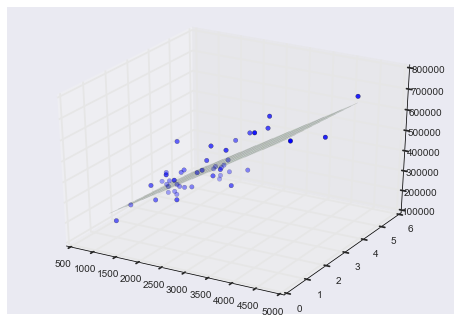

In [6]:
plot_regression(X, y, None, None, fit_equation(X, y))

### Способ второй: градиентный спуск 

In [7]:
def normalize(data, means, stds):
    return (data - means) / stds

def normalize_transform(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0) 
    return normalize(X, means, stds), means, stds
    
def cost_function(y_pred, y):
    return np.sum((y_pred - y) ** 2) / (2 * y_pred.size)
    
def fit_gradient_descent(X, y, alpha=0.01, draw_figure=False):
    # нормализация данных для быстрой сходимости
    X, means, stds = normalize_transform(X) # z-score
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    line = np.zeros((X.shape[1]))
    convergence = np.array([cost_function(X.dot(line), y)])
    for i in range(10000): # максимум 10000 итераций
        line -= float(alpha) / X.shape[0] * np.sum((X.dot(line) - y) * X.T, axis=1)
        convergence = np.append(convergence, cost_function(X.dot(line), y))
        if convergence[-1] > convergence[-2]:
            print(u'learning rate is too big')
            break
        if (convergence[-2] - convergence[-1]) / convergence[-1] < 1E-3:
            # Сходимость
            break           
    if draw_figure:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(np.arange(convergence.size), convergence)
    return line, means, stds
    
    
    

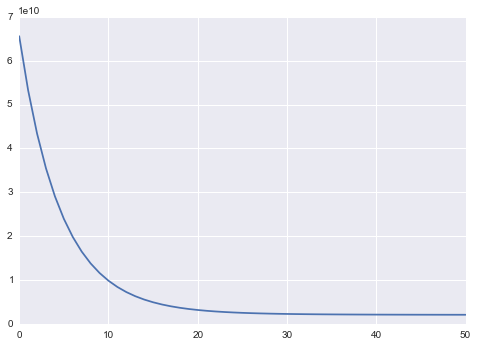

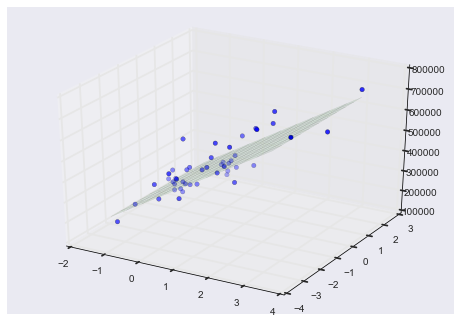

In [8]:
#%matplotlib qt 
line, means, stds = fit_gradient_descent(X, y, 0.1, True)
plot_regression(normalize(X, means, stds), y, None, None, line)


Теперь сравним эти два способа и способ из стандартной библиотеки с помощью кроссвалидации.

В качестве метрики будем использовать RMSE

rmse: min, mean, max: 36911.5393075, 64124.4926758, 124408.94011


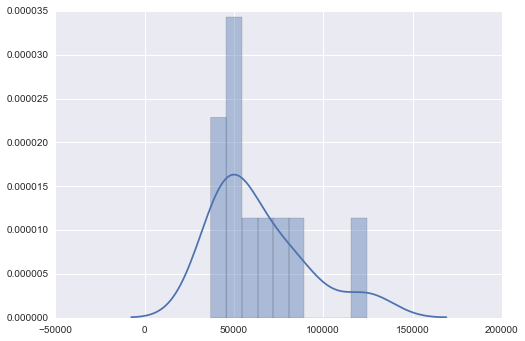

In [9]:
results = np.array([])
for train, test in sklearn.cross_validation.KFold(X.shape[0], n_folds=10):
    X_train, X_test, Y_train, Y_test = X[train], X[test], y[train], y[test]
    params = fit_equation(X_train, Y_train)
#   plot_regression(X_train, Y_train, X_test, Y_test, params)
    results = np.append(results, np.sqrt(mse(predict(X_test, params), Y_test)))
print("rmse: min, mean, max: {}, {}, {}".format(results.min(), results.mean(), results.max()))
sns.distplot(results, bins=10)
    

rmse: min, mean, max: 37531.3184709, 64806.2836254, 125858.072456


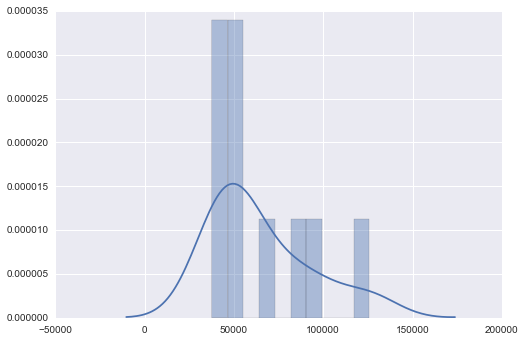

In [10]:
results = np.array([])
for train, test in sklearn.cross_validation.KFold(X.shape[0], n_folds=10):
    X_train, X_test, Y_train, Y_test = X[train], X[test], y[train], y[test]
    params, means, stds = fit_gradient_descent(X_train, Y_train)
#   plot_regression(X_train, Y_train, X_test, Y_test, params)
    results = np.append(results, np.sqrt(mse(predict(normalize(X_test, means, stds), params), Y_test)))
print("rmse: min, mean, max: {}, {}, {}".format(results.min(), results.mean(), results.max()))
sns.distplot(results, bins=10)
    

rmse: min, mean, max: 36911.5393076, 64124.4926758, 124408.94011


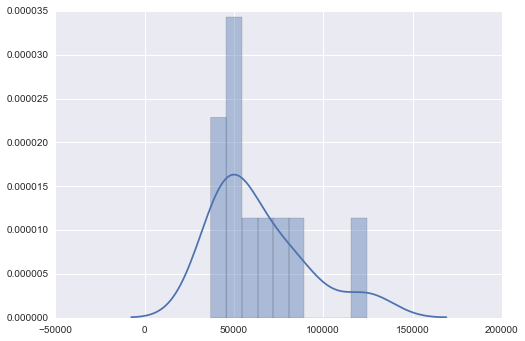

In [11]:
results = np.array([])
for train, test in sklearn.cross_validation.KFold(X.shape[0], n_folds=10):
    X_train, X_test, Y_train, Y_test = X[train], X[test], y[train], y[test]
    regression = sklearn.linear_model.LinearRegression()
    regression.fit(X_train, Y_train)
#   plot_regression(X_train, Y_train, X_test, Y_test, params)
    results = np.append(results, np.sqrt(mse(regression.predict(X_test), Y_test)))
print("rmse: min, mean, max: {}, {}, {}".format(results.min(), results.mean(), results.max()))
sns.distplot(results, bins=10)
    

Обсудить:
Проблему выбросов, регуляризацию (Тихонов, ridge, l2)

Сложность алгоритмов (O(NP^2) у обычной регрессии, Градиентный спуск – я хз как это оценивать)